<a href="https://colab.research.google.com/github/NotAndex/Demo/blob/main/time_series_forecasting_gluonts_deepar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import os
import datetime

#download yfinance package
!pip install yfinance
import yfinance as yf
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

!pip install --upgrade mxnet~=1.7 gluonts
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation import Evaluator
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas

IPython.display.clear_output()

#2 BTC-USD dataset
In this Demo the data will be downloaded from finance.yahoo.com [Data provided by CoinMarketCap.com] with help of the yfinance project. This data contains the financial time series common features Date, Open, High, Low, Close, and Volume of the last three years for the price (USD) of Bitcoin.

In [63]:
today = datetime.date.today()
start_date = today - datetime.timedelta(days=365*4)
symbol = 'BTC-USD'
cc_data = yf.download(symbol, start=start_date, end=today)

[*********************100%***********************]  1 of 1 completed


In case of missing indices (dates), the dates will be added with the value of 0. gluonts DeepAR can handle missing values but not missing indices.

In [64]:
idx = pd.date_range(start_date, today)
print(f'cc_data len: {len(cc_data)} vs. expected len: {len(idx)} || missing indices: {len(idx)-len(cc_data)}')
cc_data.index = pd.DatetimeIndex(cc_data.index)
cc_data = cc_data.reindex(idx, fill_value=0)
print(f'updated cc_data len: {len(cc_data)}')



cc_data len: 1457 vs. expected len: 1461 || missing indices: 4
updated cc_data len: 1461


Defining `pred_len` which is the forecasting horizon and `train_test_cutoff` which is the split point of the data set measured from the end.

In [46]:
pred_len = 7
train_test_cutoff = 150

Defining training_data as gluonts’ `ListDataset()`.

`“start”` and `“target”` are pretty much self-explanatory. 

`“feat_dynmic_real”` must be a list of series [series, series,…].
* `cc_data.drop(['Close', 'Adj Close'], axis=1)[:-train_test_cutoff]`
selects all the features respectively excludes the target.  
* `[df[col] for col in df]`converts the pandas DataFrame into a list of series.







In [65]:
training_data = ListDataset(
    [{"start": cc_data.index[0],
      "target": cc_data.Close[:-train_test_cutoff],
      "feat_dynamic_real": [cc_data.drop(['Close', 'Adj Close'], axis=1)[:-train_test_cutoff][col] for col in cc_data.drop(['Close', 'Adj Close'], axis=1)[:-train_test_cutoff]]}],
      freq = "D")

In [48]:
estimator = DeepAREstimator(freq="D",context_length = 7, prediction_length=pred_len, trainer=Trainer(epochs=15), use_feat_dynamic_real =True)
predictor = estimator.train(training_data=training_data)


100%|██████████| 50/50 [00:02<00:00, 18.92it/s, epoch=1/15, avg_epoch_loss=9.07]

100%|██████████| 50/50 [00:02<00:00, 20.27it/s, epoch=2/15, avg_epoch_loss=8.15]

100%|██████████| 50/50 [00:02<00:00, 19.83it/s, epoch=3/15, avg_epoch_loss=8.06]

100%|██████████| 50/50 [00:02<00:00, 19.90it/s, epoch=4/15, avg_epoch_loss=7.94]

100%|██████████| 50/50 [00:02<00:00, 20.14it/s, epoch=5/15, avg_epoch_loss=7.9]

100%|██████████| 50/50 [00:02<00:00, 19.84it/s, epoch=6/15, avg_epoch_loss=7.8]

100%|██████████| 50/50 [00:02<00:00, 20.11it/s, epoch=7/15, avg_epoch_loss=7.83]

100%|██████████| 50/50 [00:02<00:00, 20.18it/s, epoch=8/15, avg_epoch_loss=7.82]

100%|██████████| 50/50 [00:02<00:00, 20.34it/s, epoch=9/15, avg_epoch_loss=7.78]

100%|██████████| 50/50 [00:02<00:00, 20.17it/s, epoch=10/15, avg_epoch_loss=7.78]

100%|██████████| 50/50 [00:02<00:00, 19.75it/s, epoch=11/15, avg_epoch_loss=7.74]

100%|██████████| 50/50 [00:02<00:00, 19.51it/s, epoch=12/15, avg_epoch_loss=7.77]

100%|█████████

In [49]:
test_stack = []
for i in range(len(cc_data)-train_test_cutoff,len(cc_data)+1-pred_len):
  test_stack.append({"start": cc_data.index[0], "target": cc_data.Close[:i+pred_len],"feat_dynamic_real": [cc_data.drop(['Close', 'Adj Close'], axis=1)[:i+pred_len][col] for col in cc_data.drop(['Close', 'Adj Close'], axis=1)[:i+pred_len]]})

test_data = ListDataset(
    test_stack,
    freq = "D")

In [50]:
from itertools import islice
from gluonts.evaluation.backtest import make_evaluation_predictions

def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(24, 5), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()

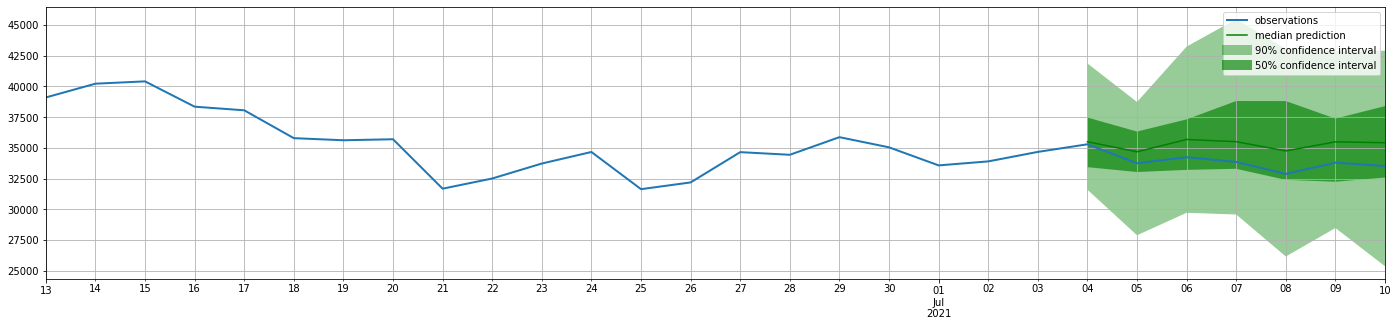

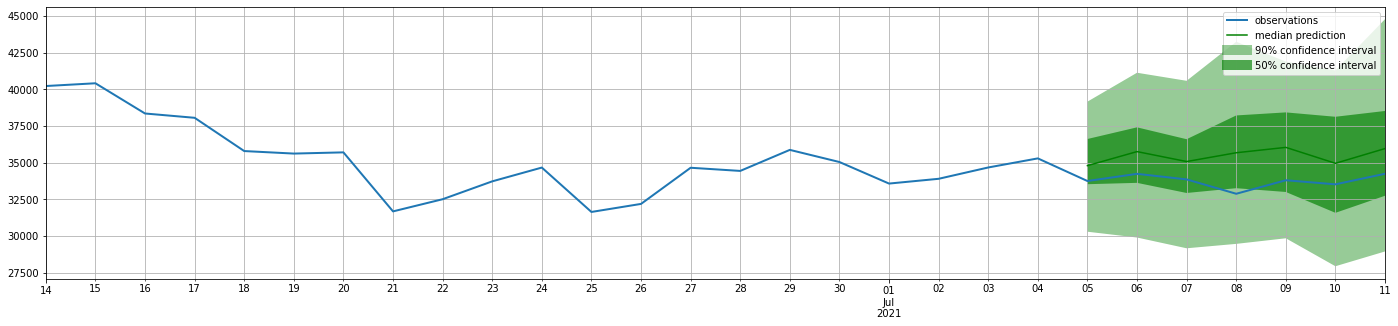

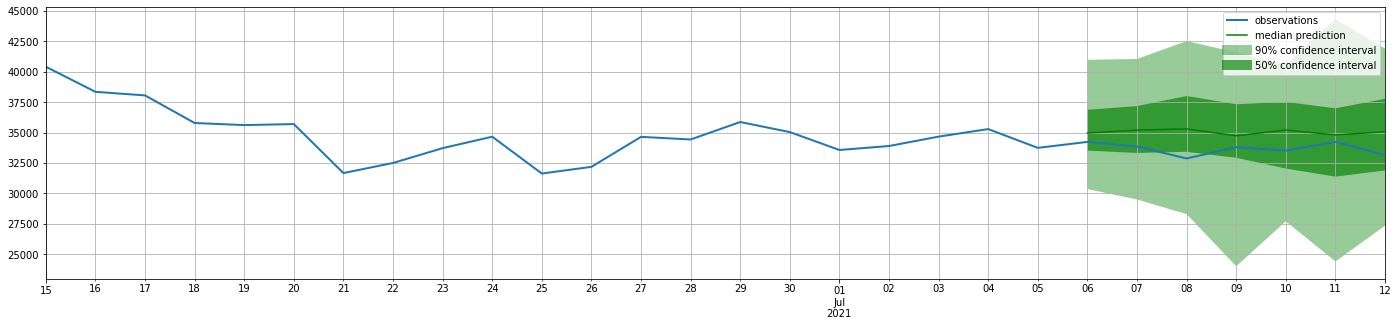

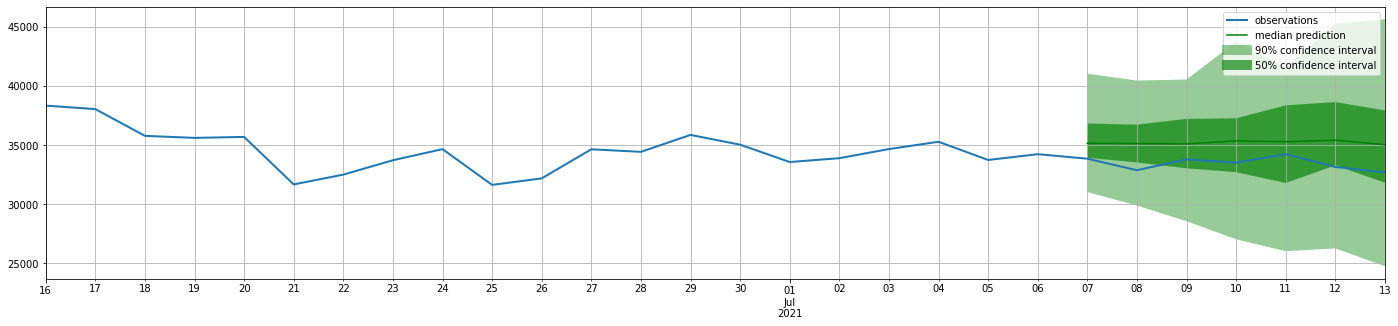

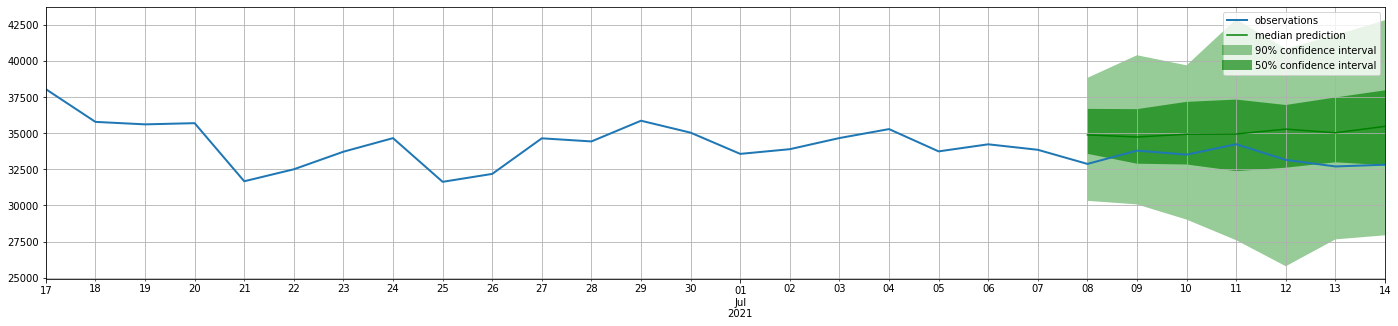

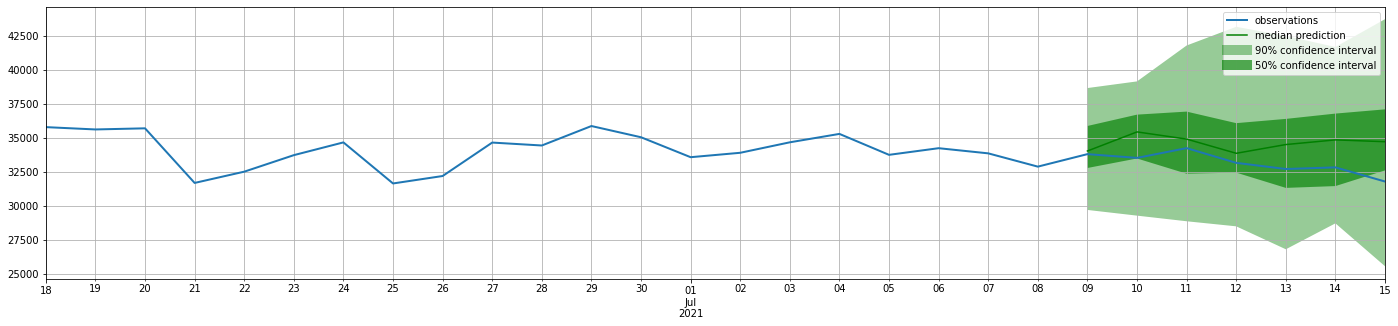

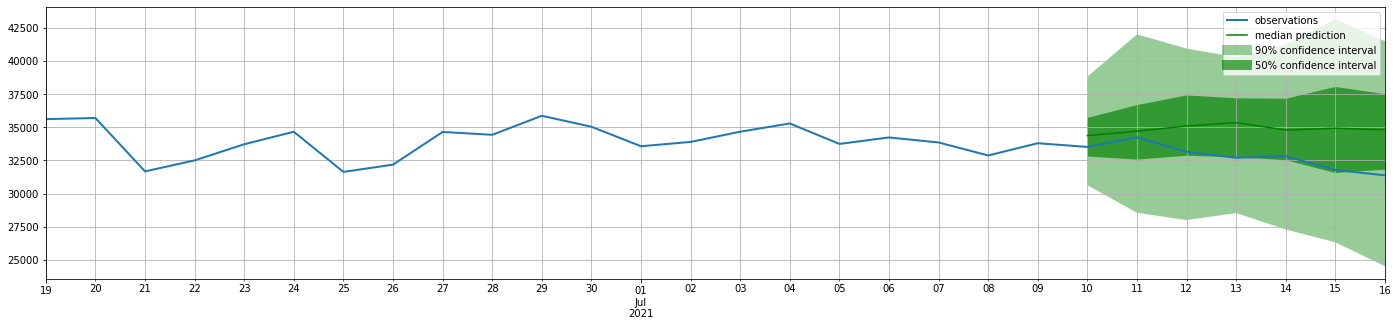

In [51]:
forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=predictor, num_samples=100)
forecasts = list(forecast_it)
tss = list(ts_it)
plot_forecasts(tss[-pred_len:], forecasts[-pred_len:], past_length=28, num_plots=pred_len)

In [52]:
evaluator = Evaluator(quantiles=[0.5])

agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))
agg_metrics


Running evaluation: 100%|██████████| 144/144 [00:00<00:00, 3228.65it/s]


{'Coverage[0.5]': 0.6299603174603172,
 'MAE_Coverage': 0.12996031746031722,
 'MAPE': 0.08275780796502084,
 'MASE': 9.634117354736587,
 'MSE': 26024817.15798612,
 'MSIS': 71.17609275807548,
 'ND': 0.07911711008848857,
 'NRMSE': 0.10764891935250236,
 'OWA': nan,
 'QuantileLoss[0.5]': 3779332.619140625,
 'RMSE': 5101.452455721421,
 'abs_error': 3779332.625,
 'abs_target_mean': 47389.72287326389,
 'abs_target_sum': 47768840.65625,
 'mean_absolute_QuantileLoss': 3779332.619140625,
 'mean_wQuantileLoss': 0.07911710996582755,
 'sMAPE': 0.07817418298255358,
 'seasonal_error': 397.15021240403775,
 'wQuantileLoss[0.5]': 0.07911710996582755}